
1.   model: DeepLabV3Plus

1-1 CelebAMask 이미지 라벨만들기


In [1]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm

In [2]:
label_list = ['skin', 'nose', 'eye_g', 'l_eye', 'r_eye', 'l_brow', 'r_brow', 'l_ear', 'r_ear', 'mouth', 'u_lip', 'l_lip', 'hair', 'hat', 'ear_r', 'neck_l', 'neck', 'cloth']

folder_base = './CelebAdataset/CelebAMask-HQ/CelebAMask-HQ-mask-anno'
folder_save = './CelebAdataset/CelebAMask-HQ/CelebAMask_label'
img_num = 30000

for k in tqdm(range(img_num)):
    folder_num = k // 2000
    im_base = np.zeros((512, 512))
    for idx, label in enumerate(label_list):
        filename = f"{folder_base}/{folder_num}/{k:0>5}_{label}.png"
        if (os.path.exists(filename)):
            im = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
            im_base[im != 0] = (idx + 1)

    filename_save = f"{folder_save}/{k}.png"
    cv2.imwrite(filename_save, im_base)

100%|██████████| 30000/30000 [11:50<00:00, 42.24it/s]


1-1-1 mask를 train valid 로 나누기

In [2]:
for path in glob('./CelebAdataset/*'):
    print(len(glob(path+'/*')))

9


In [3]:
all_mask = glob('./CelebAdataset/CelebAMask-HQ/CelebAMask_label/*')
print(len(all_mask))

30000


In [4]:
import random
random.shuffle(all_mask)

In [5]:
cnt = int(len(all_mask)*0.9)
train = all_mask[:cnt]
valid = all_mask[cnt:]
print(len(train))
print(len(valid))

27000
3000


In [10]:
import shutil
for path in tqdm(train):
    shutil.copy(path, path.replace('./CelebAdataset/CelebAMask-HQ/CelebAMask_label', './CelebAdataset/CelebAMask-HQ/train_mask'))

100%|██████████| 27000/27000 [00:01<00:00, 25374.92it/s]


In [12]:
import shutil
for path in tqdm(valid):
    shutil.copy(path, path.replace('./CelebAdataset/CelebAMask-HQ/CelebAMask_label', './CelebAdataset/CelebAMask-HQ/valid_mask'))

100%|██████████| 3000/3000 [00:00<00:00, 24830.95it/s]


1-2 image dataset/loader 정의

In [6]:
import os
import copy
from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler
from torchvision import transforms

In [7]:
import numpy as np

In [8]:
class CelebAMaskDataset():
    def __init__(self, img_path, label_path, transform_img, transform_label):
        self.img_path = img_path
        self.label_path = label_path
        self.transform_img = transform_img
        self.transform_label = transform_label
        self.dataset = glob(f'{label_path}/*')

    def __getitem__(self, index):
        label_path = self.dataset[index] 
        img_path = label_path.replace(self.label_path, self.img_path).replace('png', 'jpg')
        image = Image.open(img_path)
        label = Image.open(label_path)
        img, la = self.transform_img(image), self.transform_label(label)

        return img, la

    def __len__(self):
        """Return the number of images."""
        return len(self.dataset)

In [9]:
transform_Image = transforms.Compose([
        transforms.Resize(512),
        transforms.ToTensor()
    ])
transform_Label = transforms.Compose([
        transforms.Resize(512),
        transforms.ToTensor()
    ])

In [10]:
train_dataset = CelebAMaskDataset('./CelebAdataset/CelebAMask-HQ/CelebA-HQ-img', './CelebAdataset/CelebAMask-HQ/train_mask', transform_Image, transform_Label)
valid_dataset = CelebAMaskDataset('./CelebAdataset/CelebAMask-HQ/CelebA-HQ-img', './CelebAdataset/CelebAMask-HQ/valid_mask', transform_Image, transform_Label)

In [11]:
train_dataloaders = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=8)
valid_dataloaders = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=8)

input image


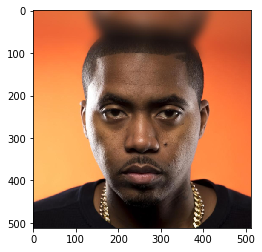

mask image


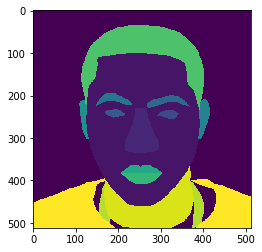

[[[ 0.]
  [ 0.]
  [ 0.]
  ...
  [ 0.]
  [ 0.]
  [ 0.]]

 [[ 0.]
  [ 0.]
  [ 0.]
  ...
  [ 0.]
  [ 0.]
  [ 0.]]

 [[ 0.]
  [ 0.]
  [ 0.]
  ...
  [ 0.]
  [ 0.]
  [ 0.]]

 ...

 [[18.]
  [18.]
  [18.]
  ...
  [18.]
  [18.]
  [18.]]

 [[18.]
  [18.]
  [18.]
  ...
  [18.]
  [18.]
  [18.]]

 [[18.]
  [18.]
  [18.]
  ...
  [18.]
  [18.]
  [18.]]]


In [12]:
dataset = iter(train_dataset)
img, label = next(dataset)
img, label = img.numpy().transpose((1, 2, 0)), label.numpy().transpose((1, 2, 0))

print('input image')
plt.imshow(np.int32(img*255))
plt.show()

print('mask image')
plt.imshow(np.int32(label*255).reshape(512,512))
plt.show()
print(label*255)

1-3 model

In [13]:
import segmentation_models_pytorch as smp
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = smp.DeepLabV3Plus(classes=19)
model.to(device)

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [14]:
import torch.nn.functional as F
def cross_entropy2d(input, target, weight=None, size_average=True):
    n, c, h, w = input.size()  
    nt, ht, wt = target.size()  

    if h != ht or w != wt:
        input = F.interpolate(input, size=(ht, wt), mode="bilinear", align_corners=True) 

    input = input.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c) 
    target = target.view(-1)
    loss = F.cross_entropy(input, target)
    return loss

In [15]:
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), 0.0002, [.5, .999])
scheduler=None
num_epochs=50

In [16]:
def generate_label_plain(inputs, imsize=512):
    pred_batch = []
    for input in inputs:
        input = input.view(1, 19, imsize, imsize)
        pred = np.squeeze(input.data.max(1)[1].cpu().numpy(), axis=0)
        pred_batch.append(pred)

    pred_batch = np.array(pred_batch)
    pred_batch = torch.from_numpy(pred_batch)
            
    label_batch = []
    for p in pred_batch:
        label_batch.append(p.numpy())
                
    label_batch = np.array(label_batch)

    return label_batch

 Epoch[1/50] train : runing_Loss 0.21413: 100%|██████████| 6750/6750 [12:43<00:00,  8.84it/s]
 Epoch[1/50] valid : valid_acc 0.16835827325781186 valid_iou 0.7570884227752686: 100%|██████████| 750/750 [00:31<00:00, 23.95it/s]


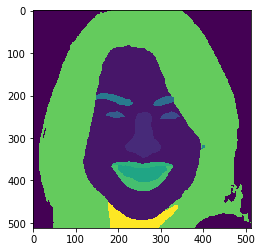

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 0 ----------


 Epoch[2/50] train : runing_Loss 0.15780: 100%|██████████| 6750/6750 [12:51<00:00,  8.75it/s]
 Epoch[2/50] valid : valid_acc 0.15302445183694363 valid_iou 0.7632132768630981: 100%|██████████| 750/750 [00:31<00:00, 23.90it/s]


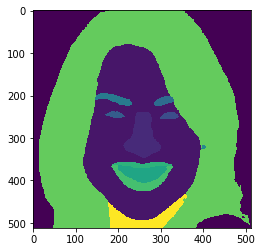

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 1 ----------


 Epoch[3/50] train : runing_Loss 0.14223: 100%|██████████| 6750/6750 [12:52<00:00,  8.74it/s]
 Epoch[3/50] valid : valid_acc 0.1453500032176574 valid_iou 0.7628774046897888: 100%|██████████| 750/750 [00:31<00:00, 23.92it/s] 


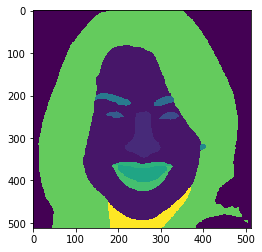

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 1 ----------


 Epoch[4/50] train : runing_Loss 0.13178: 100%|██████████| 6750/6750 [12:51<00:00,  8.75it/s]
 Epoch[4/50] valid : valid_acc 0.13887261901795864 valid_iou 0.7643189430236816: 100%|██████████| 750/750 [00:31<00:00, 23.99it/s]


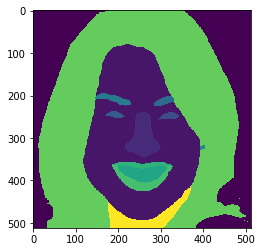

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 3 ----------


 Epoch[5/50] train : runing_Loss 0.12336: 100%|██████████| 6750/6750 [12:51<00:00,  8.75it/s]
 Epoch[5/50] valid : valid_acc 0.13671312109629313 valid_iou 0.7645418047904968: 100%|██████████| 750/750 [00:31<00:00, 23.98it/s]


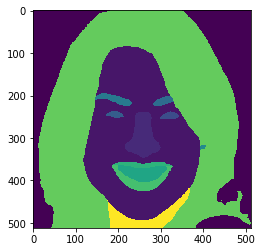

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[6/50] train : runing_Loss 0.11687: 100%|██████████| 6750/6750 [12:50<00:00,  8.76it/s]
 Epoch[6/50] valid : valid_acc 0.1400598468283812 valid_iou 0.7627490162849426: 100%|██████████| 750/750 [00:31<00:00, 23.98it/s] 


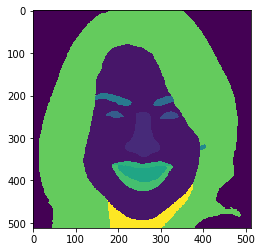

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[7/50] train : runing_Loss 0.11084: 100%|██████████| 6750/6750 [12:51<00:00,  8.75it/s]
 Epoch[7/50] valid : valid_acc 0.1359729326715072 valid_iou 0.7635645270347595: 100%|██████████| 750/750 [00:31<00:00, 23.92it/s] 


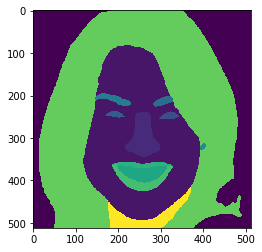

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[8/50] train : runing_Loss 0.10553: 100%|██████████| 6750/6750 [12:51<00:00,  8.75it/s]
 Epoch[8/50] valid : valid_acc 0.14161686997612316 valid_iou 0.7627997994422913: 100%|██████████| 750/750 [00:31<00:00, 23.94it/s]


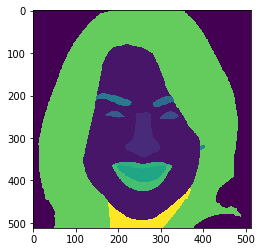

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[9/50] train : runing_Loss 0.10120: 100%|██████████| 6750/6750 [12:51<00:00,  8.75it/s]
 Epoch[9/50] valid : valid_acc 0.1445009360164404 valid_iou 0.7622876763343811: 100%|██████████| 750/750 [00:31<00:00, 23.92it/s] 


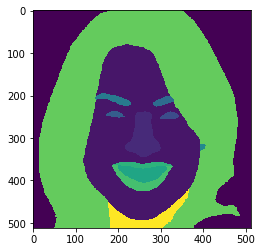

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[10/50] train : runing_Loss 0.09681: 100%|██████████| 6750/6750 [12:51<00:00,  8.75it/s]
 Epoch[10/50] valid : valid_acc 0.139472901592652 valid_iou 0.7637211680412292: 100%|██████████| 750/750 [00:31<00:00, 23.86it/s]  


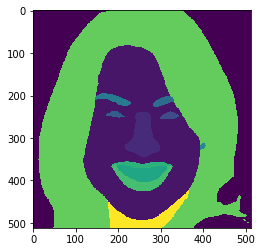

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[11/50] train : runing_Loss 0.09296: 100%|██████████| 6750/6750 [12:51<00:00,  8.75it/s]
 Epoch[11/50] valid : valid_acc 0.14209758292635283 valid_iou 0.7622429132461548: 100%|██████████| 750/750 [00:31<00:00, 23.95it/s]


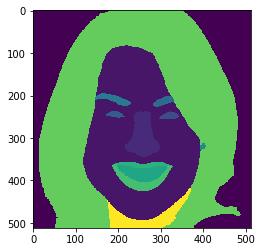

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[12/50] train : runing_Loss 0.09001: 100%|██████████| 6750/6750 [12:50<00:00,  8.76it/s]
 Epoch[12/50] valid : valid_acc 0.14486778864264488 valid_iou 0.7632559537887573: 100%|██████████| 750/750 [00:31<00:00, 23.97it/s]


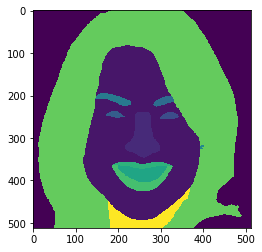

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[13/50] train : runing_Loss 0.08661: 100%|██████████| 6750/6750 [12:52<00:00,  8.73it/s]
 Epoch[13/50] valid : valid_acc 0.1529738644361496 valid_iou 0.7621532082557678: 100%|██████████| 750/750 [00:31<00:00, 23.99it/s] 


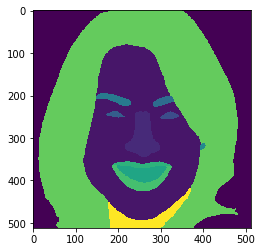

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[14/50] train : runing_Loss 0.08387: 100%|██████████| 6750/6750 [12:52<00:00,  8.73it/s]
 Epoch[14/50] valid : valid_acc 0.1454915610353152 valid_iou 0.7633472681045532: 100%|██████████| 750/750 [00:31<00:00, 23.79it/s] 


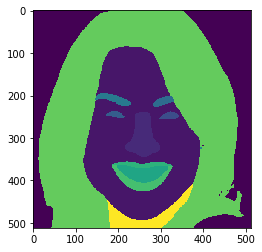

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[15/50] train : runing_Loss 0.08045: 100%|██████████| 6750/6750 [12:53<00:00,  8.73it/s]
 Epoch[15/50] valid : valid_acc 0.15666955230136712 valid_iou 0.763271152973175: 100%|██████████| 750/750 [00:31<00:00, 23.80it/s] 


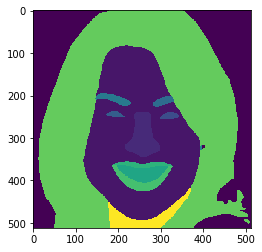

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[16/50] train : runing_Loss 0.07784: 100%|██████████| 6750/6750 [12:53<00:00,  8.72it/s]
 Epoch[16/50] valid : valid_acc 0.15395828195412953 valid_iou 0.7626969218254089: 100%|██████████| 750/750 [00:31<00:00, 23.81it/s]


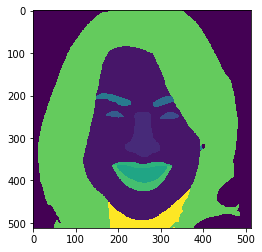

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[17/50] train : runing_Loss 0.07514: 100%|██████████| 6750/6750 [12:53<00:00,  8.73it/s]
 Epoch[17/50] valid : valid_acc 0.1570047667225202 valid_iou 0.7636191844940186: 100%|██████████| 750/750 [00:31<00:00, 23.75it/s] 


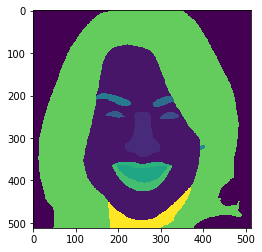

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[18/50] train : runing_Loss 0.07292: 100%|██████████| 6750/6750 [12:52<00:00,  8.74it/s]
 Epoch[18/50] valid : valid_acc 0.16262502606213092 valid_iou 0.7634339928627014: 100%|██████████| 750/750 [00:31<00:00, 23.86it/s]


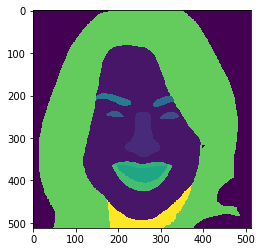

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[19/50] train : runing_Loss 0.07060: 100%|██████████| 6750/6750 [12:51<00:00,  8.75it/s]
 Epoch[19/50] valid : valid_acc 0.1624578721274932 valid_iou 0.7630804777145386: 100%|██████████| 750/750 [00:31<00:00, 23.87it/s] 


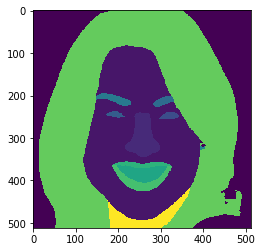

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[20/50] train : runing_Loss 0.06806: 100%|██████████| 6750/6750 [12:50<00:00,  8.76it/s]
 Epoch[20/50] valid : valid_acc 0.16338018039862315 valid_iou 0.7621524930000305: 100%|██████████| 750/750 [00:31<00:00, 23.89it/s]


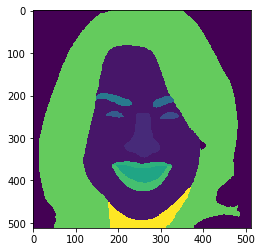

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[21/50] train : runing_Loss 0.06651: 100%|██████████| 6750/6750 [12:51<00:00,  8.75it/s]
 Epoch[21/50] valid : valid_acc 0.17035924330353736 valid_iou 0.76352459192276: 100%|██████████| 750/750 [00:31<00:00, 23.91it/s]  


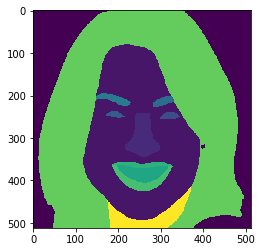

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[22/50] train : runing_Loss 0.06447: 100%|██████████| 6750/6750 [12:51<00:00,  8.75it/s]
 Epoch[22/50] valid : valid_acc 0.17423296789328258 valid_iou 0.7628565430641174: 100%|██████████| 750/750 [00:31<00:00, 23.89it/s]


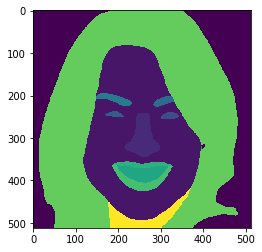

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[23/50] train : runing_Loss 0.06287: 100%|██████████| 6750/6750 [12:51<00:00,  8.75it/s]
 Epoch[23/50] valid : valid_acc 0.18102602343261243 valid_iou 0.7627975344657898: 100%|██████████| 750/750 [00:31<00:00, 23.94it/s]


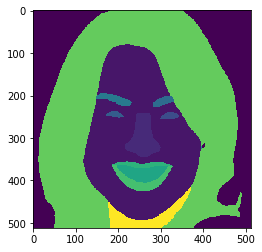

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[24/50] train : runing_Loss 0.06091: 100%|██████████| 6750/6750 [12:52<00:00,  8.73it/s]
 Epoch[24/50] valid : valid_acc 0.1830044545630614 valid_iou 0.7625463604927063: 100%|██████████| 750/750 [00:31<00:00, 23.94it/s] 


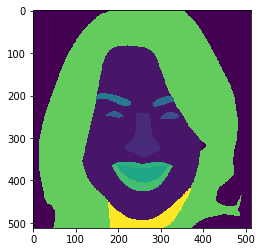

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[25/50] train : runing_Loss 0.05912: 100%|██████████| 6750/6750 [12:51<00:00,  8.75it/s]
 Epoch[25/50] valid : valid_acc 0.19018819863597552 valid_iou 0.7623686194419861: 100%|██████████| 750/750 [00:31<00:00, 23.95it/s]


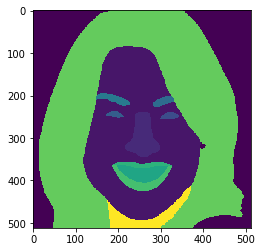

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[26/50] train : runing_Loss 0.05812: 100%|██████████| 6750/6750 [12:51<00:00,  8.75it/s]
 Epoch[26/50] valid : valid_acc 0.18693183610836664 valid_iou 0.762779951095581: 100%|██████████| 750/750 [00:31<00:00, 23.84it/s] 


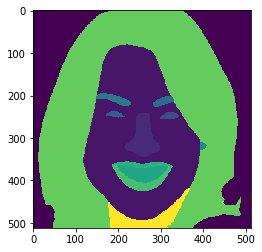

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[27/50] train : runing_Loss 0.05658: 100%|██████████| 6750/6750 [12:51<00:00,  8.75it/s]
 Epoch[27/50] valid : valid_acc 0.1869955763320128 valid_iou 0.7631375789642334: 100%|██████████| 750/750 [00:31<00:00, 23.90it/s] 


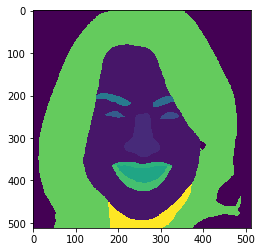

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[28/50] train : runing_Loss 0.05522: 100%|██████████| 6750/6750 [12:51<00:00,  8.75it/s]
 Epoch[28/50] valid : valid_acc 0.1933204027911027 valid_iou 0.7628558874130249: 100%|██████████| 750/750 [00:31<00:00, 23.86it/s] 


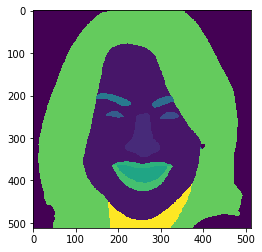

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[29/50] train : runing_Loss 0.05451: 100%|██████████| 6750/6750 [12:50<00:00,  8.76it/s]
 Epoch[29/50] valid : valid_acc 0.19815157313644885 valid_iou 0.7625887989997864: 100%|██████████| 750/750 [00:31<00:00, 23.77it/s]


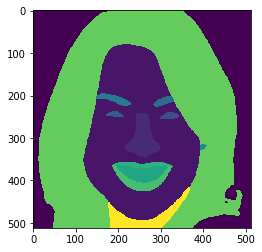

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[30/50] train : runing_Loss 0.05289: 100%|██████████| 6750/6750 [12:52<00:00,  8.74it/s]
 Epoch[30/50] valid : valid_acc 0.20162470455964407 valid_iou 0.7628026604652405: 100%|██████████| 750/750 [00:31<00:00, 23.96it/s]


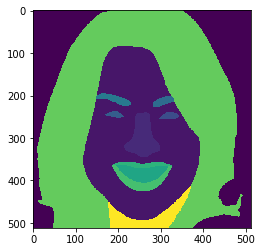

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[31/50] train : runing_Loss 0.05158: 100%|██████████| 6750/6750 [12:51<00:00,  8.74it/s]
 Epoch[31/50] valid : valid_acc 0.20508462945620218 valid_iou 0.7630680203437805: 100%|██████████| 750/750 [00:31<00:00, 23.95it/s]


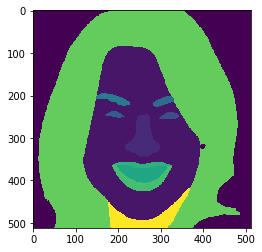

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[32/50] train : runing_Loss 0.05096: 100%|██████████| 6750/6750 [12:51<00:00,  8.74it/s]
 Epoch[32/50] valid : valid_acc 0.20953880789875984 valid_iou 0.7627953290939331: 100%|██████████| 750/750 [00:31<00:00, 23.85it/s]


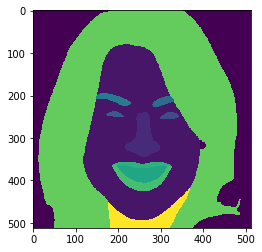

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[33/50] train : runing_Loss 0.05008: 100%|██████████| 6750/6750 [12:51<00:00,  8.74it/s]
 Epoch[33/50] valid : valid_acc 0.20211936835447947 valid_iou 0.7625463604927063: 100%|██████████| 750/750 [00:31<00:00, 23.90it/s]


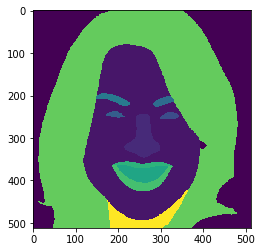

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[34/50] train : runing_Loss 0.04898: 100%|██████████| 6750/6750 [12:51<00:00,  8.75it/s]
 Epoch[34/50] valid : valid_acc 0.20546915246546268 valid_iou 0.763479471206665: 100%|██████████| 750/750 [00:31<00:00, 23.78it/s] 


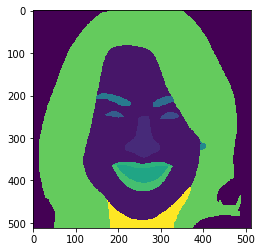

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[35/50] train : runing_Loss 0.04784: 100%|██████████| 6750/6750 [12:51<00:00,  8.75it/s]
 Epoch[35/50] valid : valid_acc 0.21380821345746517 valid_iou 0.7628129720687866: 100%|██████████| 750/750 [00:31<00:00, 23.82it/s]


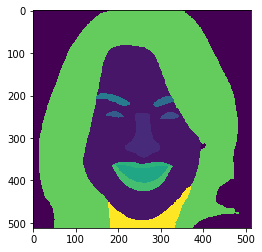

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[36/50] train : runing_Loss 0.04757: 100%|██████████| 6750/6750 [12:50<00:00,  8.76it/s]
 Epoch[36/50] valid : valid_acc 0.2177206112841765 valid_iou 0.7629349827766418: 100%|██████████| 750/750 [00:31<00:00, 23.97it/s] 


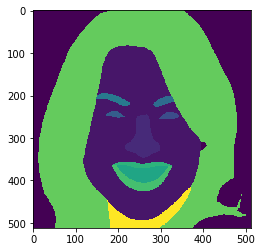

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[37/50] train : runing_Loss 0.04607: 100%|██████████| 6750/6750 [12:50<00:00,  8.76it/s]
 Epoch[37/50] valid : valid_acc 0.22095943586528302 valid_iou 0.7631595134735107: 100%|██████████| 750/750 [00:31<00:00, 23.86it/s]


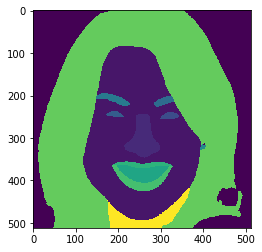

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[38/50] train : runing_Loss 0.04587: 100%|██████████| 6750/6750 [12:50<00:00,  8.76it/s]
 Epoch[38/50] valid : valid_acc 0.2260559534529845 valid_iou 0.7628695964813232: 100%|██████████| 750/750 [00:31<00:00, 23.88it/s] 


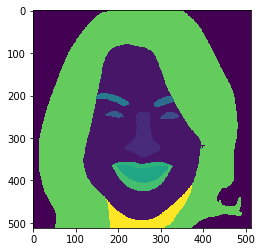

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[39/50] train : runing_Loss 0.04450: 100%|██████████| 6750/6750 [12:50<00:00,  8.76it/s]
 Epoch[39/50] valid : valid_acc 0.22833935210108758 valid_iou 0.7631548047065735: 100%|██████████| 750/750 [00:31<00:00, 23.98it/s]


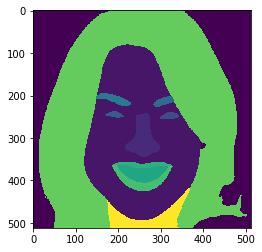

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[40/50] train : runing_Loss 0.04401: 100%|██████████| 6750/6750 [12:51<00:00,  8.75it/s]
 Epoch[40/50] valid : valid_acc 0.23025896940131982 valid_iou 0.7627988457679749: 100%|██████████| 750/750 [00:31<00:00, 23.91it/s]


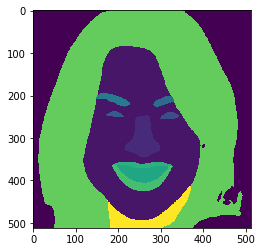

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[41/50] train : runing_Loss 0.04321: 100%|██████████| 6750/6750 [12:51<00:00,  8.75it/s]
 Epoch[41/50] valid : valid_acc 0.23702029524743556 valid_iou 0.7628864645957947: 100%|██████████| 750/750 [00:31<00:00, 23.76it/s]


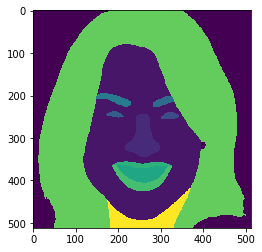

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[42/50] train : runing_Loss 0.04248: 100%|██████████| 6750/6750 [12:53<00:00,  8.73it/s]
 Epoch[42/50] valid : valid_acc 0.23662829608718555 valid_iou 0.7630452513694763: 100%|██████████| 750/750 [00:31<00:00, 23.82it/s]


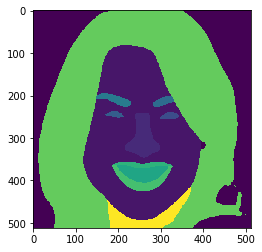

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[43/50] train : runing_Loss 0.04177: 100%|██████████| 6750/6750 [12:53<00:00,  8.72it/s]
 Epoch[43/50] valid : valid_acc 0.2383573410063982 valid_iou 0.7632359266281128: 100%|██████████| 750/750 [00:31<00:00, 23.94it/s] 


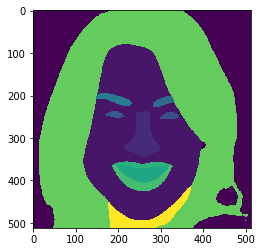

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[44/50] train : runing_Loss 0.04122: 100%|██████████| 6750/6750 [12:51<00:00,  8.75it/s]
 Epoch[44/50] valid : valid_acc 0.2385570869743824 valid_iou 0.7629508376121521: 100%|██████████| 750/750 [00:31<00:00, 23.81it/s] 


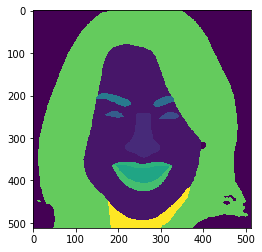

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[45/50] train : runing_Loss 0.04062: 100%|██████████| 6750/6750 [12:52<00:00,  8.74it/s]
 Epoch[45/50] valid : valid_acc 0.24158545129497846 valid_iou 0.7632948160171509: 100%|██████████| 750/750 [00:31<00:00, 23.75it/s]


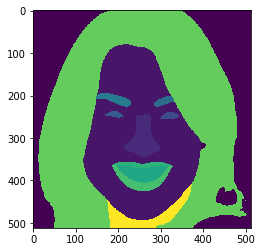

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[46/50] train : runing_Loss 0.04003: 100%|██████████| 6750/6750 [12:52<00:00,  8.74it/s]
 Epoch[46/50] valid : valid_acc 0.24180027826627096 valid_iou 0.7635451555252075: 100%|██████████| 750/750 [00:31<00:00, 23.85it/s]


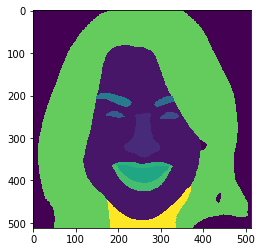

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[47/50] train : runing_Loss 0.03988: 100%|██████████| 6750/6750 [12:51<00:00,  8.74it/s]
 Epoch[47/50] valid : valid_acc 0.251497258151571 valid_iou 0.7628697752952576: 100%|██████████| 750/750 [00:31<00:00, 23.79it/s]  


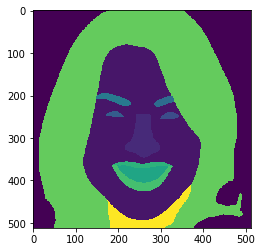

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[48/50] train : runing_Loss 0.03888: 100%|██████████| 6750/6750 [12:51<00:00,  8.75it/s]
 Epoch[48/50] valid : valid_acc 0.2515903807133436 valid_iou 0.7630258798599243: 100%|██████████| 750/750 [00:31<00:00, 23.76it/s] 


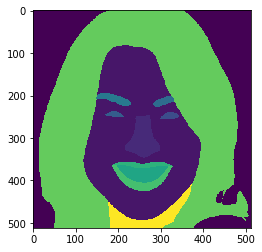

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[49/50] train : runing_Loss 0.03906: 100%|██████████| 6750/6750 [12:51<00:00,  8.75it/s]
 Epoch[49/50] valid : valid_acc 0.2546357570340236 valid_iou 0.7632383704185486: 100%|██████████| 750/750 [00:31<00:00, 23.78it/s] 


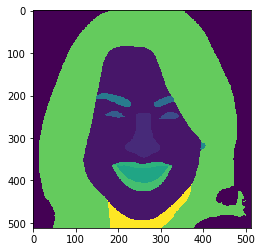

  0%|          | 0/6750 [00:00<?, ?it/s]

---------- best epoch : 4 ----------


 Epoch[50/50] train : runing_Loss 0.03980: 100%|██████████| 6750/6750 [12:51<00:00,  8.75it/s]
 Epoch[50/50] valid : valid_acc 0.24949692105253538 valid_iou 0.7636575698852539: 100%|██████████| 750/750 [00:31<00:00, 23.83it/s]


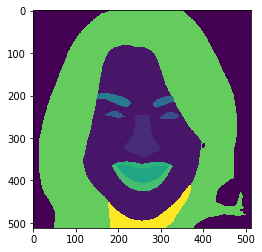

---------- best epoch : 4 ----------


In [17]:
best_model_wts = copy.deepcopy(model.state_dict())
best_iou = 0.0

for epoch in range(num_epochs):
    running_loss = 0.0
    train_corrects = 0
    train_data_cnt = 0
    train_progress_bar = tqdm(train_dataloaders) 
    for inputs, labels in train_progress_bar:
        model.train()
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        size = labels.size()
        labels[:, 0, :, :] = labels[:, 0, :, :] * 255.0
        labels_real_plain = labels[:, 0, :, :].cuda()

        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels_real_plain.long())

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        train_data_cnt += inputs.size(0)
        train_progress_bar.set_description(f" Epoch[{epoch+1}/{num_epochs}] train : runing_Loss {running_loss / train_data_cnt:.5f}")
        
    if scheduler:
        scheduler.step()

    valid_loss = 0
    valid_data_cnt = 0
    val_iou = 0
    valid_progress_bar = tqdm(valid_dataloaders)
    for inputs, labels in valid_progress_bar:    
        model.eval()
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.no_grad ():
            outputs = model(inputs)

        labels_predict_plain = generate_label_plain(outputs)

        intersection = torch.logical_and(labels, torch.tensor(labels_predict_plain).cuda())
        union = torch.logical_or(labels, torch.tensor(labels_predict_plain).cuda())
        val_iou += torch.sum(intersection) / torch.sum(union) * inputs.size(0)

        size = labels.size()
        labels[:, 0, :, :] = labels[:, 0, :, :] * 255.0
        labels_real_plain = labels[:, 0, :, :].cuda()
        loss = criterion(outputs, labels_real_plain.long())
        
        valid_loss += loss.item() * inputs.size(0)
        valid_data_cnt += inputs.size(0)
        valid_progress_bar.set_description(f" Epoch[{epoch+1}/{num_epochs}] valid : valid_acc {valid_loss / valid_data_cnt} valid_iou {val_iou / valid_data_cnt}")
    
    plt.imshow(labels_predict_plain[0])
    plt.show()

    epoch_iou = val_iou / valid_data_cnt
    if epoch_iou > best_iou:
        best_iou = epoch_iou
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
    print('-'*10, f"best epoch : {best_epoch}", '-'*10)